In [0]:
import numpy as np

import tensorflow as tf

import numpy as np

import time, math
from tqdm import tqdm_notebook as tqdm


import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [2]:
import os
os.getcwd()
from google.colab import drive
import os
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/Colab Notebooks/eva_research_team4/src/' #change dir to your project folder

os.chdir('/content/' + root_path)
os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Colab Notebooks/eva_research_team4/src'

In [3]:
from all_models import DavidNet

import run_util


from importlib import reload
reload(run_util)

from run_util import Run

import data_pipeline

reload(data_pipeline)

#from densenext import DenseNext

Using TensorFlow backend.


<module 'data_pipeline' from '/content/gdrive/My Drive/Colab Notebooks/eva_research_team4/src/data_pipeline.py'>

In [4]:
data_pipeline.get_data(dataset_name = "CIFAR10", tfrecords_flag=True)

saving to tf records
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded cifar-10-python.tar.gz 170498071 bytes.
Generating ../data/train/train.tfrecords


Generating ../data/eval/eval.tfrecords
getting tf records complete


In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.95 #@param {type:"number"}

MIN_MOMENTUM = 0.8 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 1 #@param {type:"integer"}


MIN_LEARNING_RATE = 0.000001 #@param {type:"number"}

END_LR_SMOOTHING_PERC = 0.15 #@param {type:"number"}

COMMENTS = "DenseNext Run1" #@param {type:"string"}


params_tune = {
    
  "epochs":EPOCHS, 
 
  "batch_size" : BATCH_SIZE,

  "max_lr": LEARNING_RATE,

  "min_lr":MIN_LEARNING_RATE,

  "end_anneal_pc":END_LR_SMOOTHING_PERC,

  "max_mom":MOMENTUM,
 
  "min_mom":MIN_MOMENTUM,
 
  "wd":WEIGHT_DECAY,
  
  "skip_testing_epochs":0,
    
  "batches_per_epoch":50000//BATCH_SIZE,
    
  "comments":COMMENTS
}

In [0]:
loaded_tfrecs = data_pipeline.load_tfrecords(params_tune["batch_size"])

train_dataset = loaded_tfrecs["train"]

eval_dataset = loaded_tfrecs["eval"]

###### Running only on 50 images, just for integration tests

In [0]:
model = DavidNet(f_filter=64)

obj = Run()

In [0]:
train_mean = np.array([125.30691805, 122.95039414, 113.86538318])

train_std= np.array([62.99321928, 62.08870764, 66.70489964])

normalize = lambda x: ((x - train_mean) / train_std)

def data_aug_train(x, y):
    
    #x = tf.image.per_image_standardization(x)
    
    x = normalize(x)
        
    #x = tf.image.random_flip_left_right(x)
    
    paddings = [(4, 4), (4, 4), (0, 0)]
    
    x = tf.pad(x, paddings, "REFLECT")
    
    x = tf.random_crop(x, [32, 32, 3])
    
    return (x, y)
  
def data_aug_test(x, y):
    
    #x = tf.image.per_image_standardization(x)
    
    x = normalize(x)
        
    #x = tf.image.random_flip_left_right(x)
    
    #paddings = [(4, 4), (4, 4), (0, 0)]
    
    #x = tf.pad(x, paddings, "REFLECT")
    
    #x = tf.random_crop(x, [32, 32, 3])
    
    return (x, y)

### LR Finder

Creating a separate data supplier for lr finder

In [0]:

def tst_data_supplier_lr(epoch_num):
    
    batch_size = params_tune["batch_size"]
    
    global eval_dataset
  
    len_test = 100

    test_set = eval_dataset.take(100).map(data_aug_test).batch(batch_size).prefetch(1)
    
    return (test_set, len_test)

def trn_data_supplier_lr(epoch_num):
    
    batch_size = params_tune["batch_size"]
  
    global train_dataset
    
    len_train = 1500

    train_set = train_dataset.take(len_train).map(data_aug_train).batch(batch_size).prefetch(1)
    
    return (train_set, len_train)

In [0]:
#obj.lr_finder(model_fn, lr_list=[0.0001, 0.0002, 0.0003, 0.0004, 0.0007, 0.001, 0.004, 0.007, 0.01, 0.05, 0.09, 0.1, 0.4, 0.7, 0.9, 1, 2, 7, 10, 20, 40, 70, 100], tst_data_supplier=tst_data_supplier_lr,
#             trn_data_supplier=trn_data_supplier_lr)

# Train

In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.95 #@param {type:"number"}

MIN_MOMENTUM = 0.8 #@param {type:"number"}
LEARNING_RATE = 1 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 50 #@param {type:"integer"}


MIN_LEARNING_RATE = 0.000001 #@param {type:"number"}

END_LR_SMOOTHING_PERC = 0.15 #@param {type:"number"}

COMMENTS = "DavidNet run1" #@param {type:"string"}


params_tune = {
    
  "epochs":EPOCHS, 
 
  "batch_size" : BATCH_SIZE,

  "max_lr": LEARNING_RATE,

  "min_lr":MIN_LEARNING_RATE,

  "end_anneal_pc":END_LR_SMOOTHING_PERC,

  "max_mom":MOMENTUM,
 
  "min_mom":MIN_MOMENTUM,
 
  "wd":WEIGHT_DECAY,
  
  "skip_testing_epochs":0,
    
  "batches_per_epoch":50000//BATCH_SIZE,
    
  "comments":COMMENTS
}

In [0]:
def tst_data_supplier(epoch_num):
    
    batch_size = params_tune["batch_size"]
    
    global eval_dataset
  
    len_test = 10000

    test_set = eval_dataset.map(data_aug_test).batch(batch_size).prefetch(1)
    
    return (test_set, len_test)

def trn_data_supplier(epoch_num):
    
    batch_size = params_tune["batch_size"]
  
    global train_dataset
    
    len_train = 50000

    train_set = train_dataset.map(data_aug_train).batch(batch_size).prefetch(1)
    
    return (train_set, len_train)

In [11]:
x = obj.run(params_tune, trn_data_supplier, tst_data_supplier, model=model)

epoch: 1 lr: 0.1 train loss: 1.566 train acc:0.433 val loss: 1.180 val acc: 0.572 time:85.787
epoch: 2 lr: 0.2 train loss: 0.976 train acc:0.652 val loss: 0.758 val acc: 0.731 time:155.294
epoch: 3 lr: 0.30000000000000004 train loss: 0.753 train acc:0.736 val loss: 0.691 val acc: 0.761 time:224.707
epoch: 4 lr: 0.4 train loss: 0.614 train acc:0.786 val loss: 0.897 val acc: 0.711 time:294.234
epoch: 5 lr: 0.5 train loss: 0.544 train acc:0.814 val loss: 0.621 val acc: 0.794 time:363.797
epoch: 6 lr: 0.6000000000000001 train loss: 0.400 train acc:0.861 val loss: 0.675 val acc: 0.785 time:433.234
epoch: 7 lr: 0.7000000000000001 train loss: 0.310 train acc:0.892 val loss: 0.525 val acc: 0.831 time:502.622
epoch: 8 lr: 0.8 train loss: 0.247 train acc:0.916 val loss: 0.568 val acc: 0.830 time:572.113
epoch: 9 lr: 0.9 train loss: 0.195 train acc:0.933 val loss: 0.693 val acc: 0.812 time:641.723
epoch: 10 lr: 1.0 train loss: 0.154 train acc:0.948 val loss: 0.589 val acc: 0.841 time:711.268
epoc

In [0]:
obj.model.summary()

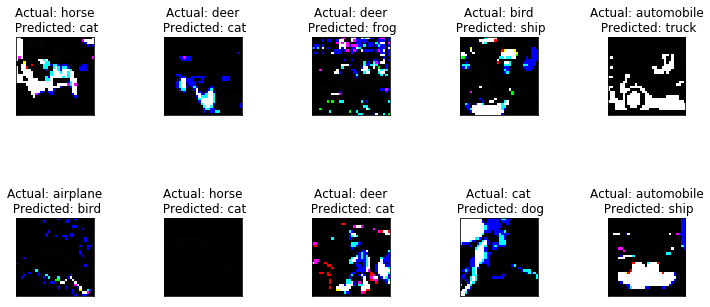

In [0]:
obj.show_missclassified_images(num_images=10, tst_data_supplier=tst_data_supplier)

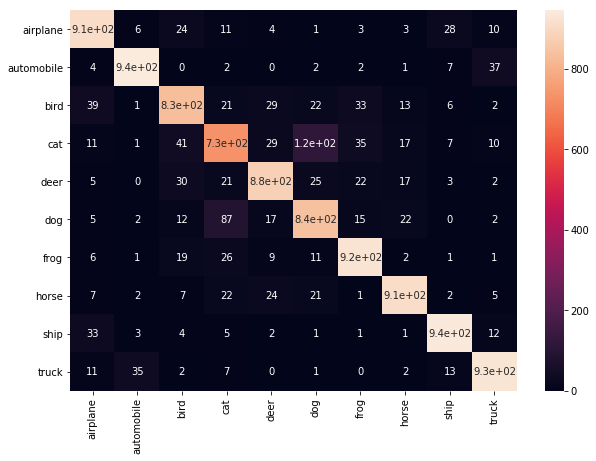

In [0]:
obj.plot_confusion_matrix(tst_data_supplier=tst_data_supplier)

### Grid Search

In [0]:
params_tune_grid = {
    
  "epochs":[2, 3] ,
 
  "batch_size" : [16, 25],

  "max_lr": [0.1, 0.4],

  "min_lr":[MIN_LEARNING_RATE],

  "end_anneal_pc":[END_LR_SMOOTHING_PERC],

  "max_mom":[MOMENTUM],
 
  "min_mom":[MIN_MOMENTUM],
 
  "wd":[WEIGHT_DECAY],
  
  "skip_testing_epochs":[0],
    
  "batches_per_epoch":[50000//BATCH_SIZE],
    
   "comments":["GRID SEARCH RUNS"]
}

obj.grid_search(model_fn, params_tune_grid, trn_data_supplier, tst_data_supplier)


   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       2          16     0.1  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    3.397303       0.08      0.06  0.0005    2.451632   

   test_loss                                               runs  \
0   2.341633  {'epoch': [1, 2], 'time': [1.8279533386230469,...   

              log_time          comments  
0  2019-09-03 06:55:07  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       2          16     0.4  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    3.421345       0.12      0.08  0.0005    2.316013   

   test_loss                                               runs  \
0   2.334704  {'epoch': [1, 2], 'time': [1.8045012950897217,...   

              log_time          comments  
0  2019-09-03 06:55:10  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       2          25     0.1  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    3.337093       0.02      0.18  0.0005     2.60887   

   test_loss                                               runs  \
0   2.534968  {'epoch': [1, 2], 'time': [1.7697594165802002,...   

              log_time          comments  
0  2019-09-03 06:55:14  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       2          25     0.4  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    3.346182       0.08      0.08  0.0005    2.511127   

   test_loss                                               runs  \
0   2.365659  {'epoch': [1, 2], 'time': [1.761902093887329, ...   

              log_time          comments  
0  2019-09-03 06:55:17  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       3          16     0.1  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    4.968339       0.14       0.1  0.0005    2.486274   

   test_loss                                               runs  \
0    2.32517  {'epoch': [1, 2, 3], 'time': [1.76265525817871...   

              log_time          comments  
0  2019-09-03 06:55:22  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       3          16     0.4  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    4.979783       0.04      0.06  0.0005     2.42462   

   test_loss                                               runs  \
0   2.293442  {'epoch': [1, 2, 3], 'time': [1.78953599929809...   

              log_time          comments  
0  2019-09-03 06:55:27  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       3          25     0.1  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    4.944698       0.18      0.08  0.0005    2.301014   

   test_loss                                               runs  \
0   2.355996  {'epoch': [1, 2, 3], 'time': [1.75519990921020...   

              log_time          comments  
0  2019-09-03 06:55:32  GRID SEARCH RUNS  



   total_model_parameters  epochs  batch_size  max_lr    min_lr  anneal_perc  \
0                  343264       3          25     0.4  0.000001         0.15   

   max_mom  min_mom  time_taken  train_acc  test_acc      wd  train_loss  \
0     0.95      0.8    4.967406       0.12      0.06  0.0005    2.379765   

   test_loss                                               runs  \
0    2.33608  {'epoch': [1, 2, 3], 'time': [1.80100154876708...   

              log_time          comments  
0  2019-09-03 06:55:37  GRID SEARCH RUNS  


({'epochs': 2,
  'batch_size': 25,
  'max_lr': 0.1,
  'min_lr': 1e-06,
  'end_anneal_pc': 0.15,
  'max_mom': 0.95,
  'min_mom': 0.8,
  'wd': 0.0005,
  'skip_testing_epochs': 0,
  'batches_per_epoch': 2000,
  'comments': 'GRID SEARCH RUNS'},
 0.18)

##### Viewing log

In [0]:
import pandas as pd

pd.read_csv("../data/run_logger.csv").tail()

,total_model_parameters,epochs,batch_size,max_lr,min_lr,anneal_perc,max_mom,min_mom,time_taken,train_acc,test_acc,wd,train_loss,test_loss,runs,log_time,comments
115,343264,2,25,0.4,0.000001,0.15,0.95,0.8,3.346182,0.08,0.08,0.0005,2.511127,2.365659,"{'epoch': [1, 2], 'time': [1.761902093887329, ...",2019-09-03 06:55:17,GRID SEARCH RUNS
116,343264,3,16,0.1,0.000001,0.15,0.95,0.8,4.968339,0.14,0.10,0.0005,2.486274,2.325170,"{'epoch': [1, 2, 3], 'time': [1.76265525817871...",2019-09-03 06:55:22,GRID SEARCH RUNS
117,343264,3,16,0.4,0.000001,0.15,0.95,0.8,4.979783,0.04,0.06,0.0005,2.424620,2.293442,"{'epoch': [1, 2, 3], 'time': [1.78953599929809...",2019-09-03 06:55:27,GRID SEARCH RUNS
118,343264,3,25,0.1,0.000001,0.15,0.95,0.8,4.944698,0.18,0.08,0.0005,2.301014,2.355996,"{'epoch': [1, 2, 3], 'time': [1.75519990921020...",2019-09-03 06:55:32,GRID SEARCH RUNS
119,343264,3,25,0.4,0.000001,0.15,0.95,0.8,4.967406,0.12,0.06,0.0005,2.379765,2.336080,"{'epoch': [1, 2, 3], 'time': [1.80100154876708...",2019-09-03 06:55:37,GRID SEARCH RUNS


#### Numpy implementation

x_train, y_train, x_test, y_test = data_pipeline.load_saved_numpy_data(
    train_path=["../data/train/train_x.npy","../data/train/train_y.npy"],
    test_path=["../data/test/test_x.npy", "../data/test/test_y.npy"])

def tst_data_supplier(epoch_num):
    
    batch_size = params_tune["batch_size"]
    
    global eval_dataset
  
    len_test = x_test[0].shape[0]

    test_set = tf.data.Dataset.from_tensor_slices((x_test[:30,:,:,:],
                                                   y_test[:30])).batch(batch_size).prefetch(1)
    
    return (test_set, len_test)

def trn_data_supplier(epoch_num):
    
    batch_size = params_tune["batch_size"]
  
    global y_train
    
    global x_train
    
    len_test = x_train[0].shape[0]

    test_set = tf.data.Dataset.from_tensor_slices((x_train[:50,:,:,:], 
                                        y_train[:50])).batch(batch_size).prefetch(1)
    
    return (test_set, len_test)

def tst_data_supplier_lr(epoch, test_num_batches=2):
 
    batch_size = params_tune["batch_size"]
    
    global x_test
  
    global y_test
  
    sample_idx = np.random.choice(y_test.size, test_num_batches * batch_size, replace=False)

    x_test_lr = x_test[sample_idx, :, :, :]

    y_test_lr = y_test[sample_idx]
    
    len_test = x_test_lr[0].shape[0]

    test_set = tf.data.Dataset.from_tensor_slices((x_test_lr,
                                                   y_test_lr)).batch(batch_size).prefetch(1)

    return (test_set, len_test)

def trn_data_supplier_lr(epoch, train_num_batches=2):
 
    batch_size = params_tune["batch_size"]
    
    global x_train
  
    global y_train
  
    sample_idx = np.random.choice(y_train.size, train_num_batches * batch_size, replace=False)

    x_train_lr = x_train[sample_idx, :, :, :]

    y_train_lr = y_train[sample_idx]
    
    len_train = x_train_lr[0].shape[0]

    train_set = tf.data.Dataset.from_tensor_slices((x_train_lr,
                                                   y_train_lr)).batch(batch_size).prefetch(1)

    return (train_set, len_train)